## Case Study: The site for recommendations - "Gnod"

Antonio Montilla

### Lab | Web Scraping Single Page (GNOD part 1)
- Web scraping the top 100 songs from https://www.popvortex.com/music/charts/top-100-songs.php

In [1]:
#importing libraries
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import random
from sklearn import cluster, datasets
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
from sklearn.metrics import silhouette_score

In [2]:
#copying url
url = "https://www.popvortex.com/music/charts/top-100-songs.php"

In [3]:
#downloading html
response = requests.get(url)
response.status_code # 200 status code means OK!

200

In [4]:
#parseing html with BeatifulSoup
soup = BeautifulSoup(response.content, "html.parser")

In [5]:
#checkin the code
#soup

In [6]:
#selecting the top songs body > div.container > div:nth-child(4) > div.col-xs-12.col-md-8 > div.chart-wrapper
#print(soup.select("body > div.container > div:nth-child(4) > div.col-xs-12.col-md-8 > div.chart-wrapper > div" ))
len(soup.select("body > div.container > div:nth-child(4) > div.col-xs-12.col-md-8 > div.chart-wrapper > div" ))

105

In [7]:
#looking at first item
soup.select("body > div.container > div:nth-child(4) > div.col-xs-12.col-md-8 > div.chart-wrapper > div" )[0]

<div class="feed-item music-chart flex-row" id="chart-position-1"><div class="cover-art col-xs-12 col-sm-4"><p class="chart-position">1</p><img alt="Lil Boo Thang - Paul Russell Cover Art" class="cover-image" data-pin-description="Lil Boo Thang - Paul Russell" data-pin-media="https://is1-ssl.mzstatic.com/image/thumb/Music116/v4/ea/5d/dc/ea5ddcb8-66c6-c3ab-e268-41e2d8d675a0/196871378383.jpg/1200x1200bb.png" data-pin-url="https://www.popvortex.com/music/charts/top-100-songs.php" height="170" loading="lazy" src="https://is1-ssl.mzstatic.com/image/thumb/Music116/v4/ea/5d/dc/ea5ddcb8-66c6-c3ab-e268-41e2d8d675a0/196871378383.jpg/170x170bb.png" width="170"/> <audio controls="" controlslist="nodownload" preload="none"><source src="https://audio-ssl.itunes.apple.com/itunes-assets/AudioPreview116/v4/e3/76/0d/e3760d9a-714b-b1ba-df37-779294dba12f/mzaf_12464091131482397794.plus.aac.p.m4a"/></audio> </div><div class="chart-content col-xs-12 col-sm-8"><p class="title-artist"><cite class="title">Lil B

In [8]:
artists = []
songs = []
target_classes = ['feed-item', 'music-chart', 'flex-row', 'new-release'] #I had to add different class as only using 'flex-row' would exclude some songs
chart_entries = soup.find_all('div', class_=target_classes)
for entry in chart_entries:
    title_artist = entry.find('p', class_='title-artist')
    if title_artist:
        title = title_artist.find('cite', class_='title').text.strip()
        artist = title_artist.find('em', class_='artist').text.strip()
        artists.append(artist)
        songs.append(title)

hot_songs = pd.DataFrame({"artist":artists, "song":songs})

In [9]:
#checking the dataframe
print(len(hot_songs))
hot_songs.drop_duplicates()
print(len(hot_songs))
#deleting the first row which was repeated:
hot_songs.drop(index=hot_songs.index[0], axis=0, inplace=True)
hot_songs.reset_index()
hot_songs

101
101


,artist,song
1,Paul Russell,Lil Boo Thang
2,Jimmy Fallon & Meghan Trainor,Wrap Me Up
3,Jack Harlow,Lovin On Me
4,Drew Holcomb & The Neighbors,Find Your People
5,Cher,DJ Play A Christmas Song
...,...,...
96,Tate McRae,exes
97,Dolly Parton,Heart of Glass (feat. Debbie Harry)
98,Drake,Evil Ways (feat. J. Cole)
99,blink-182,ONE MORE TIME


In [10]:
hot_songs.to_csv('hot_songs', index = False)

### Extending the hot_songs df using billboard public information

For the second lab, I want to extend the hot_songs dataframe using top 100 song from Billborad published here: https://www.billboard.com/charts/greatest-hot-100-singles/

In [11]:
#copying url
url = "https://www.billboard.com/charts/greatest-hot-100-singles/"

In [12]:
#downloading html
response = requests.get(url)
response.status_code # 200 status code means OK!

200

In [13]:
#parseing html with BeatifulSoup
soup = BeautifulSoup(response.content, "html.parser")

In [14]:
#checkin the code
#soup

In [15]:
#selecting the top songs #post-6760926 > div.pmc-paywall > div
#soup.select("#post-6760926 > div.pmc-paywall > div > div")

In [16]:
#now creating the dataframe
artists = []
songs = []
chart_rows = soup.select('.o-chart-results-list-row')
for row in chart_rows:
    title_element = row.select_one('.c-title')
    artist_element = row.select_one('.c-label')
    if title_element and artist_element:
        title = title_element.text.strip()
        artist = row.select_one('.c-label').find_next('span', class_='c-label').text.strip()
        songs.append(title)
        artists.append(artist)
    
hot_songs2 = pd.DataFrame({"artist":artists, "song":songs})

In [17]:
hot_songs2

,artist,song
0,The Weeknd,Blinding Lights
1,Chubby Checker,The Twist
2,Santana Featuring Rob Thomas,Smooth
3,Bobby Darin,Mack The Knife
4,Mark Ronson Featuring Bruno Mars,Uptown Funk!
...,...,...
95,Donna Summer,Hot Stuff
96,Post Malone Featuring 21 Savage,Rockstar
97,Coolio Featuring L.V.,Gangsta's Paradise
98,The Steve Miller Band,Abracadabra


In [18]:
#appending the two df
hot_songs_all = hot_songs.append(hot_songs2, ignore_index=True)
hot_songs_all

/var/folders/ws/0xbhg9d95hd9g5nvrfz8pwk40000gn/T/ipykernel_25623/999307168.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hot_songs_all = hot_songs.append(hot_songs2, ignore_index=True)


,artist,song
0,Paul Russell,Lil Boo Thang
1,Jimmy Fallon & Meghan Trainor,Wrap Me Up
2,Jack Harlow,Lovin On Me
3,Drew Holcomb & The Neighbors,Find Your People
4,Cher,DJ Play A Christmas Song
...,...,...
195,Donna Summer,Hot Stuff
196,Post Malone Featuring 21 Savage,Rockstar
197,Coolio Featuring L.V.,Gangsta's Paradise
198,The Steve Miller Band,Abracadabra


In [19]:
#saving the hot_songs into a CSV:
hot_songs_all.to_csv('hot_songs_all.csv', index=False)

## Part 2: song recommendation from hot_songs_all


Build a function that: 
1) takes as input a song title, 
2) checks if in hot_songs_all df, 
3) if so, then recommends another random song from that list, 
4) elif delivers a message with no recommendation

In [20]:
#trying the random selection 
random.choice(hot_songs_all['song']) 

'Truly Madly Deeply'

In [21]:
#trying the tolist() function
hot_songs_all['song'].str.lower().tolist()

['lil boo thang',
 'wrap me up',
 'lovin on me',
 'find your people',
 'dj play a christmas song',
 'i remember everything (feat. kacey musgraves)',
 'white horse',
 'save me (with lainey wilson)',
 'need a favor',
 'standing next to you',
 'houdini',
 'cruel summer',
 '90s rap mashup',
 'lose control',
 '3d',
 'all i want for christmas is you',
 "you're the inspiration",
 'christmas / sarajevo 12/24 (instrumental)',
 'standing next to you (band version)',
 'thinkin’ bout me',
 'standing next to you (future funk remix)',
 'fairytale of philadelphia',
 'where the wild things are',
 'standing next to you (pbr&b remix)',
 'daylight',
 'standing next to you (slow jam remix)',
 'standing next to you (holiday remix)',
 'standing next to you (latin trap remix)',
 'standing next to you (instrumental)',
 'paint the town red',
 'fast car',
 'find your people',
 "rockin' around the christmas tree (single)",
 'last night',
 'water',
 'lovin on me',
 'now and then',
 'the thanksgiving song',
 'gree

In [22]:
#now using these two steps into the function
def recommend_song(song_name, df):
    lower_case_song = song_name.lower()
    if lower_case_song in df['song'].str.lower().tolist():
        recommended_song = random.choice(df['song'])
        return f"We recommend you to listen '{recommended_song}' as well:)"
    else:
        return "Sorry, there is no recommendation at this stage"

In [23]:
recommend_song('Blinding Lights', hot_songs_all)

"We recommend you to listen 'Love Story (Taylor’s Version)' as well:)"

In [24]:
recommend_song('Fulana', hot_songs_all)

'Sorry, there is no recommendation at this stage'

## Part 3: Clustering K-means on total songs database

- In this part I will be making a clustering model in the 'songs_total_df' created using different playlist datasets using Spotify API.
- The 'songs_total_df' was created in the notebook 'API_wrappers_spotify_songs_AM.ipynb' in the same repository.
- I will be importing the CSV dataset and peform K-means clustering model that will be used in a later stage for improving the song recommendation algorithm.

In [25]:
#importing the 'songs_total' csv file
songs_total = pd.read_csv('songs_total_dataframe.csv')

In [26]:
#shape
print(songs_total.shape)
#column names
print(songs_total.columns)
#column types
print(songs_total.dtypes)

(31909, 21)
Index(['track.name', 'name', 'song_id', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 'track_href',
       'analysis_url', 'duration_ms', 'time_signature'],
      dtype='object')
track.name           object
name                 object
song_id              object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
type                 object
id                   object
uri                  object
track_href           object
analysis_url         object
duration_ms           int64
time_signature        int64
dtype: object


In [27]:
#select only numerical features from the dataframe to be used in K-means model
numerical_df = songs_total.select_dtypes(np.number)
numerical_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.755,0.553,6,-9.449,0,0.1070,0.04920,0.006070,0.0646,0.836,119.700,266600,4
1,0.667,0.667,7,-6.267,1,0.0388,0.00013,0.003850,0.0711,0.843,130.321,243213,4
2,0.826,0.601,10,-3.966,0,0.0515,0.19500,0.000003,0.0700,0.948,126.971,234000,4
3,0.905,0.945,4,-2.630,1,0.1370,0.03540,0.005290,0.0707,0.944,131.597,250693,4
4,0.797,0.536,11,-8.267,0,0.2660,0.03150,0.000029,0.1700,0.704,102.881,224800,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31904,0.439,0.610,9,-7.236,1,0.1160,0.59300,0.000011,0.3410,0.172,181.088,215508,4
31905,0.897,0.371,1,-5.019,1,0.3680,0.09040,0.000000,0.3250,0.441,81.008,156005,4
31906,0.964,0.398,11,-8.981,0,0.0795,0.00151,0.000039,0.1010,0.563,105.012,178405,4
31907,0.964,0.398,11,-8.981,0,0.0795,0.00151,0.000039,0.1010,0.563,105.012,178405,4


In [28]:
#scaling the numerical_df
Standardtransformer = StandardScaler().fit(numerical_df) #this transformer will be used later on
X_prep = Standardtransformer.transform(numerical_df)#scaling
X_prep = pd.DataFrame(X_prep,columns=numerical_df.columns)#creating df
X_prep

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.771755,-0.472241,0.187665,-0.497359,-1.150373,0.329537,-0.660694,-0.554706,-0.798196,1.257467,-0.016647,0.338965,0.140166
1,0.185880,0.115389,0.465487,0.481476,0.869283,-0.523677,-0.845878,-0.562259,-0.753010,1.285961,0.382291,0.031702,0.140166
2,1.244450,-0.224818,1.298956,1.189301,-1.150373,-0.364794,-0.110465,-0.575348,-0.760657,1.713372,0.256461,-0.089341,0.140166
3,1.770406,1.548380,-0.367981,1.600276,0.869283,0.704851,-0.712774,-0.557360,-0.755790,1.697090,0.430219,0.129975,0.140166
4,1.051378,-0.559870,1.576779,-0.133756,-1.150373,2.318702,-0.727492,-0.575261,-0.065479,0.720151,-0.648389,-0.210212,0.140166
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31904,-1.332070,-0.178426,1.021133,0.183396,0.869283,0.442132,1.391531,-0.575322,1.123275,-1.445395,2.289163,-0.332292,0.140166
31905,1.717145,-1.410386,-1.201449,0.865381,0.869283,3.594770,-0.505211,-0.575359,1.012047,-0.350410,-1.469967,-1.114055,0.140166
31906,2.163209,-1.271211,1.576779,-0.353394,-1.150373,-0.014500,-0.840670,-0.575224,-0.545152,0.146200,-0.568346,-0.819759,0.140166
31907,2.163209,-1.271211,1.576779,-0.353394,-1.150373,-0.014500,-0.840670,-0.575224,-0.545152,0.146200,-0.568346,-0.819759,0.140166


In [29]:
#pickle saving scaler
import pickle
pickle.dump(Standardtransformer, open('Standardtransformer.pkl', 'wb'))

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

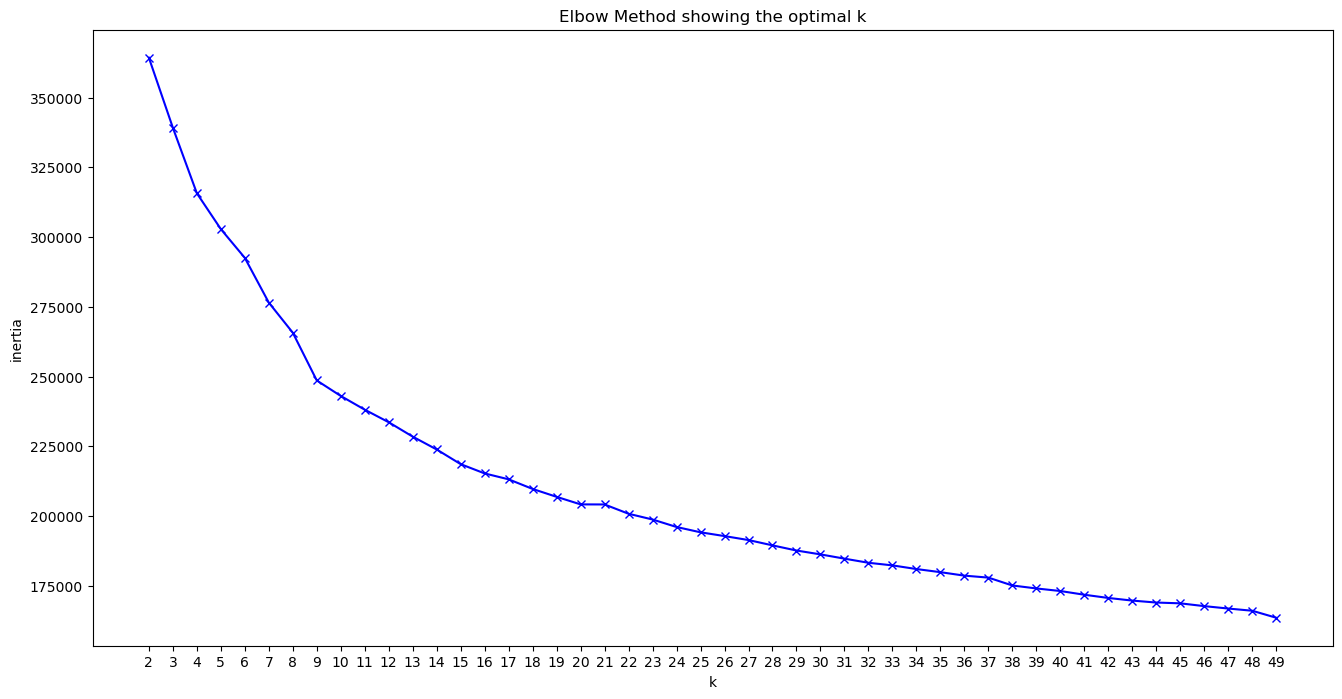

In [30]:
#building K-means clustering models to choose optimal number of K
K = range(2, 50)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k, n_init='auto', 
                    random_state=1234)
    kmeans.fit(X_prep)
    inertia.append(kmeans.inertia_)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

- The inertia chart suggests that probably the optimal value of K may be 10.
- However, **I will select K = 20 to allow a better recommendation in our song algorithm**

In [31]:
#building the model
kmeans = KMeans(n_clusters=20, n_init='auto', random_state=1234)
kmeans.fit(X_prep)

KMeans(n_clusters=20, n_init='auto', random_state=1234)

In [32]:
#pickle saving kmeans model
pickle.dump(kmeans, open('kmean.pkl', 'wb'))

In [33]:
# Predicting / assigning the clusters:
clusters = kmeans.predict(X_prep)
pd.Series(clusters).value_counts().sort_index()

0     1944
1     1843
2     1189
3     2559
4     1712
5     2311
6     1443
7     1437
8     1219
9     1756
10    2061
11    1119
12    1902
13    1756
14     108
15    1713
16    1887
17    1305
18    1364
19    1281
dtype: int64

In [34]:
#will add the category as a separate column into the songs_total dataframe:
songs_total['cluster'] = clusters
songs_total

,track.name,name,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,cluster
0,If I Ever Feel Better,Phoenix,3AA8xNhDC0MpqwkGX3EP5V,0.755,0.553,6,-9.449,0,0.1070,0.04920,...,0.836,119.700,audio_features,3AA8xNhDC0MpqwkGX3EP5V,spotify:track:3AA8xNhDC0MpqwkGX3EP5V,https://api.spotify.com/v1/tracks/3AA8xNhDC0Mp...,https://api.spotify.com/v1/audio-analysis/3AA8...,266600,4,4
1,Dance To The Underground,Radio 4,2i8lRhmZNKaM1ypHwRybuD,0.667,0.667,7,-6.267,1,0.0388,0.00013,...,0.843,130.321,audio_features,2i8lRhmZNKaM1ypHwRybuD,spotify:track:2i8lRhmZNKaM1ypHwRybuD,https://api.spotify.com/v1/tracks/2i8lRhmZNKaM...,https://api.spotify.com/v1/audio-analysis/2i8l...,243213,4,3
2,How We Do,Mount Sims,4flxgPC0426CEeSrzQIic0,0.826,0.601,10,-3.966,0,0.0515,0.19500,...,0.948,126.971,audio_features,4flxgPC0426CEeSrzQIic0,spotify:track:4flxgPC0426CEeSrzQIic0,https://api.spotify.com/v1/tracks/4flxgPC0426C...,https://api.spotify.com/v1/audio-analysis/4flx...,234000,4,16
3,Fuck the Pain Away,Peaches,1XHFob24QklIXtLRopKirJ,0.905,0.945,4,-2.630,1,0.1370,0.03540,...,0.944,131.597,audio_features,1XHFob24QklIXtLRopKirJ,spotify:track:1XHFob24QklIXtLRopKirJ,https://api.spotify.com/v1/tracks/1XHFob24QklI...,https://api.spotify.com/v1/audio-analysis/1XHF...,250693,4,5
4,Street Surgery 2,Zongamin,4JB847zlgViLq8tJIzRsZy,0.797,0.536,11,-8.267,0,0.2660,0.03150,...,0.704,102.881,audio_features,4JB847zlgViLq8tJIzRsZy,spotify:track:4JB847zlgViLq8tJIzRsZy,https://api.spotify.com/v1/tracks/4JB847zlgViL...,https://api.spotify.com/v1/audio-analysis/4JB8...,224800,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31904,deja vu,Olivia Rodrigo,61KpQadow081I2AsbeLcsb,0.439,0.610,9,-7.236,1,0.1160,0.59300,...,0.172,181.088,audio_features,61KpQadow081I2AsbeLcsb,spotify:track:61KpQadow081I2AsbeLcsb,https://api.spotify.com/v1/tracks/61KpQadow081...,https://api.spotify.com/v1/audio-analysis/61Kp...,215508,4,1
31905,WHOLE LOTTA MONEY,BIA,5yorXJWdBan1Vlh116ZtQ7,0.897,0.371,1,-5.019,1,0.3680,0.09040,...,0.441,81.008,audio_features,5yorXJWdBan1Vlh116ZtQ7,spotify:track:5yorXJWdBan1Vlh116ZtQ7,https://api.spotify.com/v1/tracks/5yorXJWdBan1...,https://api.spotify.com/v1/audio-analysis/5yor...,156005,4,15
31906,Slumber Party (feat. Princess Nokia),Ashnikko,11ZulcYY4lowvcQm4oe3VJ,0.964,0.398,11,-8.981,0,0.0795,0.00151,...,0.563,105.012,audio_features,11ZulcYY4lowvcQm4oe3VJ,spotify:track:11ZulcYY4lowvcQm4oe3VJ,https://api.spotify.com/v1/tracks/11ZulcYY4low...,https://api.spotify.com/v1/audio-analysis/11Zu...,178405,4,4
31907,Slumber Party (feat. Princess Nokia),Princess Nokia,11ZulcYY4lowvcQm4oe3VJ,0.964,0.398,11,-8.981,0,0.0795,0.00151,...,0.563,105.012,audio_features,11ZulcYY4lowvcQm4oe3VJ,spotify:track:11ZulcYY4lowvcQm4oe3VJ,https://api.spotify.com/v1/tracks/11ZulcYY4low...,https://api.spotify.com/v1/audio-analysis/11Zu...,178405,4,4


In [35]:
#saving the songs_total to csv
songs_total.to_csv('songs_total2.csv', index=False)

In [36]:
#saving also as separate csv but only with two columns song_artist and sing id
songs_total_output = songs_total[['track.name', 'name', 'cluster']]
songs_total_output.columns = ['song', 'artist', 'cluster']
songs_total_output['song_artist'] = songs_total_output['song']+' by '+songs_total_output['artist']
songs_total_output = songs_total_output.drop(['song', 'artist'], axis = 1)
songs_total_output.to_csv('songs_total_output.csv', index=False)

/var/folders/ws/0xbhg9d95hd9g5nvrfz8pwk40000gn/T/ipykernel_25623/276325922.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  songs_total_output['song_artist'] = songs_total_output['song']+' by '+songs_total_output['artist']


## Part 4: Building a song recommendation algorithm

The song recommendation algorithm will:
- Check whether or not the input song is currently a hot song, i.e. whether it is in the hot_songs_all dataframe.
- If it is, then it recommends the user another hot song.
- If it is NOT, then:
    * Collects the audio features from the Spotify API for the input song.
    * Sends the Spotify audio features of the submitted song to the clustering model, which should return a cluster number.
    * And finally recommends a song from the same cluster number.
- First, building the section that will collect the audio features from the Spotify API for the input song.
- I will then build a pre-function for this and later on merge it with the 'recommend_song' function built in step 2.

In [37]:
#importing libraries
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from random import randint
from time import sleep
from pandas import json_normalize

In [38]:
#connecting with Spotify API
secrets_file = open("secrets.txt","r")
string = secrets_file.read()
secrets_dict={}
for line in string.split('\n'):
    if len(line) > 0:
        #print(line.split(':'))
        secrets_dict[line.split(':')[0]]=line.split(':')[1].strip()

In [39]:
#Initialize SpotiPy with user credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=secrets_dict['clientid'],
                                                           client_secret=secrets_dict['clientsecret']))

In [40]:
#collect the audio features from the Spotify API for the input song
def get_song_data(song):
    #first need to obtain a request from Spotify API for all possible artists
    results = sp.search(q=song.lower(), limit=10)
    tracks = json_normalize(results["tracks"]["items"])
    def expand_list_dict(row):
        df = json_normalize(row['artists'])
        df['song_id'] = row['id']
        return df
    tracks['artists_dfs'] = tracks.apply(expand_list_dict, axis=1)
    artist_df = pd.DataFrame(columns=['external_urls.spotify', 'href', 'id', 'name', 'type', 'uri', 'song_id'])
    for mini_df in tracks['artists_dfs']:
        artist_df = pd.concat([artist_df, mini_df], axis=0)
    df_merged = pd.merge(left=tracks,
                    right=artist_df,
                    how='inner',
                    left_on='id',
                    right_on='song_id')
    #saving into a df_final the name of the song, artist and song_id associated with input song
    df_final = df_merged[['name_x', 'name_y', 'song_id']]
    #now need to confirm with user the song and artist from list.
    #if yes, then do another request to Spotify to get song data; if not, ask the user again until possible.
    row_index = 0 #so then it starts selecting the first row
    while row_index < len(df_final):
        x = input('Did you mean '+df_final['name_x'].iloc[row_index]+' by '+df_final['name_y'].iloc[row_index]+'?').lower()
        if x in ['yes', 'y', 'ys', 'es', 'si', 'oui']:
            song_info = json_normalize(sp.audio_features(df_final['song_id'].iloc[row_index]))
            break #to break the while loop
        else:
            print('ok, let me try again')
            row_index += 1 #to repeat the process but taking the next song in the df_final
    print("Storing data for the song "+df_final['name_x'].iloc[row_index]+' by '+df_final['name_y'].iloc[row_index])
    return song_info

    
    
    #in the following function, will need to: take only numericals, scale, cluster & assign randomly a song from songs_total


In [41]:
poker_face = get_song_data('poker face')

Did you mean Poker Face by Lady Gaga?si
Storing data for the song Poker Face by Lady Gaga


In [42]:
music = get_song_data('music madonna')

Did you mean Music by Madonna?si
Storing data for the song Music by Madonna


In [43]:
music

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.736,0.802,7,-8.527,1,0.0663,0.00149,0.0876,0.14,0.871,119.854,audio_features,2BcOZ4vOeu2qZowIHrvTYy,spotify:track:2BcOZ4vOeu2qZowIHrvTYy,https://api.spotify.com/v1/tracks/2BcOZ4vOeu2q...,https://api.spotify.com/v1/audio-analysis/2BcO...,225973,4


In [44]:
#building a function to assign a cluster to the input song and recommend randomly another song from same cluster
def recommend_song_part2(song_input_df):
    song_input_df = song_input_df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature']]
    song_input_df_scaled = Standardtransformer.transform(song_input_df)#scaling
    song_input_df_scaled = pd.DataFrame(song_input_df_scaled,columns=song_input_df.columns)#creating df
    cluster_song = kmeans.predict(song_input_df_scaled)
    array = songs_total_output.song_artist[songs_total_output.cluster == cluster_song[0]].reset_index(drop=True)
    recommended_song = random.choice(array)
    return f"We recommend you to listen '{recommended_song}' as well:)"

In [45]:
recommend_song_part2(music)

"We recommend you to listen 'Living in America by The Sounds' as well:)"

In [46]:
recommend_song_part2(poker_face)

"We recommend you to listen 'Bad Romance by Lady Gaga' as well:)"

## Combining all functions for the final song recommendation algorithm

In [47]:
def song_finder_bff(song_name):
    lower_case_song = song_name.lower()
    if lower_case_song in hot_songs_all['song'].str.lower().tolist():
        recommended_song = random.choice(hot_songs_all['song'])
        return f"We recommend you to listen '{recommended_song}' as well, one of top hot hits right now"
    else:
        results = sp.search(q=song_name.lower(), limit=10)
        tracks = json_normalize(results["tracks"]["items"])
        def expand_list_dict(row):
            df = json_normalize(row['artists'])
            df['song_id'] = row['id']
            return df
        tracks['artists_dfs'] = tracks.apply(expand_list_dict, axis=1)
        artist_df = pd.DataFrame(columns=['external_urls.spotify', 'href', 'id', 'name', 'type', 'uri', 'song_id'])
        for mini_df in tracks['artists_dfs']:
            artist_df = pd.concat([artist_df, mini_df], axis=0)
        df_merged = pd.merge(left=tracks,
                    right=artist_df,
                    how='inner',
                    left_on='id',
                    right_on='song_id')
        #saving into a df_final the name of the song, artist and song_id associated with input song
        df_final = df_merged[['name_x', 'name_y', 'song_id']]
        #now need to confirm with user the song and artist from list.
        #if yes, then do another request to Spotify to get song data; if not, ask the user again until possible.
        row_index = 0 #so then it starts selecting the first row
        while row_index < len(df_final):
            x = input('Did you mean '+df_final['name_x'].iloc[row_index]+' by '+df_final['name_y'].iloc[row_index]+'?').lower()
            if x in ['yes', 'y', 'ys', 'es', 'si', 'oui']:
                song_info = json_normalize(sp.audio_features(df_final['song_id'].iloc[row_index]))
                break #to break the while loop
            else:
                print('ok, let me try again')
                row_index += 1 #to repeat the process but taking the next song in the df_final
        song_input_df = song_info[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']]
        song_input_df_scaled = Standardtransformer.transform(song_input_df)#scaling
        song_input_df_scaled = pd.DataFrame(song_input_df_scaled,columns=song_input_df.columns)#creating df
        cluster_song = kmeans.predict(song_input_df_scaled)
        array = songs_total_output.song_artist[songs_total_output.cluster == cluster_song[0]].reset_index(drop=True)
        recommended_song = random.choice(array)
        return f"We recommend you to listen '{recommended_song}' as well:)"

In [48]:
song_finder_bff('poker face')

Did you mean Poker Face by Lady Gaga?si


"We recommend you to listen 'DJ Turn It Up (feat. Juize) by Heretic Klick' as well:)"

In [49]:
song_finder_bff('Shakira')

Did you mean Shakira: Bzrp Music Sessions, Vol. 53 by Bizarrap?yes


"We recommend you to listen 'Ready For The Floor by Hot Chip' as well:)"

In [51]:
#trying something from the hot list:
song_finder_bff('Blinding Lights')

"We recommend you to listen 'Flashdance...What A Feeling' as well, one of top hot hits right now"

### in a separate notebook will combine all this information and structure the algorithm 'song_finder_bff'